In [92]:
is_notebook_mode = 'get_ipython' in globals()

In [93]:
from pathlib import Path

Path("figure").mkdir(exist_ok=True)
Path("visual").mkdir(exist_ok=True)

In [94]:
from pathlib import Path
from argparse import Namespace
import pandas as pd

assert Namespace

# Get all files with format '*.latency.csv' from root_dir
# root_dir = Path("fig11-abalation-log")
root_dir = Path("result")
latency_file_paths = sorted(list(root_dir.glob("*.latency.csv")))
experiment_log_paths = sorted(list(root_dir.glob("*.log")))
columns = ['backend', 'rate', 'target', 'attainment', 'latency']

In [95]:
dfs = []
namespaces = []
for latency_file_path, experiment_log_path in zip(latency_file_paths, experiment_log_paths):
    # read experiment_log_path and log the namespace
    # with open(experiment_log_path, 'r') as f:
    #     exp_args = f.read()
    #     exp_args = eval(exp_args)
    #     namespaces.append(exp_args)

    try:
        df = pd.read_csv(latency_file_path)
    except pd.errors.EmptyDataError:
        pass
    dfs.append(df)

In [96]:
big_df = pd.concat(dfs, ignore_index=True)
big_df['ngpu'] = big_df['tp_prefill'] * big_df['pp_prefill'] + big_df['tp_decode'] * big_df['pp_decode']
big_df['per_gpu_rate'] = big_df['rate'] / big_df['ngpu']
big_df['goodput@90'] = big_df.apply(
    lambda x: x['rate'] / x['ngpu'] if x['attainment'] >= 90 else 0,
    axis=1,
)

In [97]:
big_df

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90
0,distserve,OPT-13B,prefill,10.0,200.0,31.5,1,1,1,1,2,5.0,0.0
1,distserve,OPT-13B,decode,10.0,100.0,19.7,1,1,1,1,2,5.0,0.0
2,distserve,OPT-13B,both,10.0,"(200.0, 100.0)",6.6,1,1,1,1,2,5.0,0.0
3,distserve,OPT-13B,prefill,10.0,80.0,9.4,1,1,1,1,2,5.0,0.0
4,distserve,OPT-13B,decode,10.0,40.0,4.1,1,1,1,1,2,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5920,vllm,OPT-13B,decode,8.0,53.33889345806699,95.0,4,2,0,0,8,1.0,1.0
5921,vllm,OPT-13B,prefill,8.0,133.13607455513008,98.0,4,2,0,0,8,1.0,1.0
5922,vllm,OPT-13B,decode,8.0,60.10827468892423,98.0,4,2,0,0,8,1.0,1.0
5923,vllm,OPT-13B,prefill,8.0,139.8101755435571,99.0,4,2,0,0,8,1.0,1.0


In [98]:
max_machine = 4
max_gpu_per_node = 8


def can_fit_low_affinity_distserve(x):
    a, b, c, d = x['tp_prefill'], x['pp_prefill'], x['tp_decode'], x['pp_decode']
    for pp_common in range(1, max_machine + 1):
        bp = b / pp_common
        dp = d / pp_common
        # If either bp or dp is not int, skip
        if int(bp) != bp or int(dp) != dp:
            continue
        # Check if the segment can be placed inside a node
        if a * bp + c * dp <= max_gpu_per_node:
            return True
        pass
    return False


def can_fit_low_affinity(x):
    if x['backend'] == 'distserve':
        return can_fit_low_affinity_distserve(x)
    else:
        return True
    pass


big_df['low_affin'] = big_df.apply(can_fit_low_affinity, axis=1)

In [99]:
big_df.sort_values(by=['backend', 'per_gpu_rate', 'tp_prefill', 'pp_prefill', 'tp_decode', 'pp_decode'])

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90,low_affin
1625,distserve,OPT-13B,prefill,2.0,200.0,90.0,1,1,1,1,2,1.0,1.0,True
1626,distserve,OPT-13B,decode,2.0,100.0,100.0,1,1,1,1,2,1.0,1.0,True
1627,distserve,OPT-13B,both,2.0,"(200.0, 100.0)",90.0,1,1,1,1,2,1.0,1.0,True
1628,distserve,OPT-13B,prefill,2.0,80.0,41.5,1,1,1,1,2,1.0,0.0,True
1629,distserve,OPT-13B,decode,2.0,40.0,99.5,1,1,1,1,2,1.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5645,vllm,OPT-13B,decode,40.0,1342.915130257478,95.0,4,2,0,0,8,5.0,5.0,True
5646,vllm,OPT-13B,prefill,40.0,568.1377173625623,98.0,4,2,0,0,8,5.0,5.0,True
5647,vllm,OPT-13B,decode,40.0,1499.726000652843,98.0,4,2,0,0,8,5.0,5.0,True
5648,vllm,OPT-13B,prefill,40.0,608.6635096350741,99.0,4,2,0,0,8,5.0,5.0,True


In [100]:
target = '(200.0, 100.0)'
figure_11_left_df = big_df[
    (big_df['pd'] == 'both')
    & (big_df['target'] == target)
    ].copy()

figure_11_left_df = figure_11_left_df.sort_values(by=[
    'backend', 'tp_prefill', 'pp_prefill', 'tp_decode', 'pp_decode',
    'rate'
])
# Choose the config with the best goodput in each group
figure_11_distserve_high = figure_11_left_df[
    (figure_11_left_df['backend'] == 'distserve')
]
figure_11_distserve_low = figure_11_left_df[
    (figure_11_left_df['backend'] == 'distserve')
    & (figure_11_left_df['low_affin'])
    ]
figure_11_vllm_high = figure_11_left_df[
    (figure_11_left_df['backend'] == 'vllm')
]
figure_11_vllm_low = figure_11_left_df[
    (figure_11_left_df['backend'] == 'vllm')
    & (figure_11_left_df['pp_prefill'] == 1)
    & (figure_11_left_df['tp_prefill'] == 1)
    ]


In [101]:
figure_11_distserve_high

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90,low_affin
1627,distserve,OPT-13B,both,2.0,"(200.0, 100.0)",90.000000,1,1,1,1,2,1.0,1.0,True
3327,distserve,OPT-13B,both,4.0,"(200.0, 100.0)",80.750000,1,1,1,1,2,2.0,0.0,True
3877,distserve,OPT-13B,both,6.0,"(200.0, 100.0)",54.166667,1,1,1,1,2,3.0,0.0,True
4302,distserve,OPT-13B,both,8.0,"(200.0, 100.0)",15.125000,1,1,1,1,2,4.0,0.0,True
2,distserve,OPT-13B,both,10.0,"(200.0, 100.0)",6.600000,1,1,1,1,2,5.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4627,distserve,OPT-13B,both,8.0,"(200.0, 100.0)",99.875000,4,1,4,1,8,1.0,1.0,True
1227,distserve,OPT-13B,both,16.0,"(200.0, 100.0)",96.000000,4,1,4,1,8,2.0,2.0,True
2402,distserve,OPT-13B,both,24.0,"(200.0, 100.0)",23.291667,4,1,4,1,8,3.0,0.0,True
3227,distserve,OPT-13B,both,32.0,"(200.0, 100.0)",6.093750,4,1,4,1,8,4.0,0.0,True


In [102]:
figure_11_distserve_low

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90,low_affin
1627,distserve,OPT-13B,both,2.0,"(200.0, 100.0)",90.000000,1,1,1,1,2,1.0,1.0,True
3327,distserve,OPT-13B,both,4.0,"(200.0, 100.0)",80.750000,1,1,1,1,2,2.0,0.0,True
3877,distserve,OPT-13B,both,6.0,"(200.0, 100.0)",54.166667,1,1,1,1,2,3.0,0.0,True
4302,distserve,OPT-13B,both,8.0,"(200.0, 100.0)",15.125000,1,1,1,1,2,4.0,0.0,True
2,distserve,OPT-13B,both,10.0,"(200.0, 100.0)",6.600000,1,1,1,1,2,5.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4627,distserve,OPT-13B,both,8.0,"(200.0, 100.0)",99.875000,4,1,4,1,8,1.0,1.0,True
1227,distserve,OPT-13B,both,16.0,"(200.0, 100.0)",96.000000,4,1,4,1,8,2.0,2.0,True
2402,distserve,OPT-13B,both,24.0,"(200.0, 100.0)",23.291667,4,1,4,1,8,3.0,0.0,True
3227,distserve,OPT-13B,both,32.0,"(200.0, 100.0)",6.093750,4,1,4,1,8,4.0,0.0,True


In [103]:
figure_11_vllm_high

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90,low_affin
4802,vllm,OPT-13B,both,1.0,"(200.0, 100.0)",82.000000,1,1,0,0,1,1.0,0.0,True
5102,vllm,OPT-13B,both,2.0,"(200.0, 100.0)",83.500000,1,1,0,0,1,2.0,0.0,True
5327,vllm,OPT-13B,both,3.0,"(200.0, 100.0)",75.000000,1,1,0,0,1,3.0,0.0,True
5427,vllm,OPT-13B,both,4.0,"(200.0, 100.0)",51.750000,1,1,0,0,1,4.0,0.0,True
5652,vllm,OPT-13B,both,5.0,"(200.0, 100.0)",16.200000,1,1,0,0,1,5.0,0.0,True
5127,vllm,OPT-13B,both,2.0,"(200.0, 100.0)",89.500000,1,2,0,0,2,1.0,0.0,True
5452,vllm,OPT-13B,both,4.0,"(200.0, 100.0)",84.500000,1,2,0,0,2,2.0,0.0,True
5677,vllm,OPT-13B,both,6.0,"(200.0, 100.0)",40.833333,1,2,0,0,2,3.0,0.0,True
5727,vllm,OPT-13B,both,8.0,"(200.0, 100.0)",14.125000,1,2,0,0,2,4.0,0.0,True
4827,vllm,OPT-13B,both,10.0,"(200.0, 100.0)",5.100000,1,2,0,0,2,5.0,0.0,True


In [104]:
figure_11_vllm_low

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90,low_affin
4802,vllm,OPT-13B,both,1.0,"(200.0, 100.0)",82.00,1,1,0,0,1,1.0,0.0,True
5102,vllm,OPT-13B,both,2.0,"(200.0, 100.0)",83.50,1,1,0,0,1,2.0,0.0,True
5327,vllm,OPT-13B,both,3.0,"(200.0, 100.0)",75.00,1,1,0,0,1,3.0,0.0,True
5427,vllm,OPT-13B,both,4.0,"(200.0, 100.0)",51.75,1,1,0,0,1,4.0,0.0,True
5652,vllm,OPT-13B,both,5.0,"(200.0, 100.0)",16.20,1,1,0,0,1,5.0,0.0,True


In [105]:
# Plot the `figure_11_distserve_high`for some configurations
# tp_prefill = 1, pp_prefill = 1, tp_decode = 1, pp_decode = 1
# x-axis: rate
# y-axis: attainment
# find all combination of tp_prefill, pp_prefill, tp_decode, pp_decode
import plotly.graph_objects as go

fig = go.Figure()
configs = figure_11_distserve_high[['tp_prefill', 'pp_prefill', 'tp_decode', 'pp_decode']].drop_duplicates()
df = figure_11_distserve_high

for tp_prefill, pp_prefill, tp_decode, pp_decode in configs.values:
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill) &
        (df['tp_decode'] == tp_decode) & (df['pp_decode'] == pp_decode)
        ]
    # plot this inside a plotly plot
    fig.add_trace(go.Scatter(
        x=config_df['per_gpu_rate'], y=config_df['attainment'],
        mode='lines+markers', name=f"p{tp_prefill}{pp_prefill}{tp_decode}{pp_decode}-distserve"
    ))

# fig add title
fig.update_layout(
    title="DistServe",
    xaxis_title="Per-GPU Rate (tokens/s)",
    yaxis_title="Attainment (%)",
    legend_title="Configuration"
)

# Export to html
fig.write_html("visual/figure_11_distserve_high.html")
if is_notebook_mode:
    fig.show()

In [106]:
# Plot the `figure_11_vllm_high`for some configurations
# tp_prefill = 1, pp_prefill = 1
# x-axis: rate
# y-axis: attainment
# find all combination of tp_prefill, pp_prefill
import plotly.graph_objects as go

fig = go.Figure()
configs = figure_11_vllm_high[['tp_prefill', 'pp_prefill']].drop_duplicates()
df = figure_11_vllm_high

for tp_prefill, pp_prefill in configs.values:
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill)
        ]
    # plot this inside a plotly plot
    fig.add_trace(go.Scatter(
        x=config_df['per_gpu_rate'], y=config_df['attainment'],
        mode='lines+markers', name=f"p{tp_prefill}{pp_prefill}-vllm"
    ))

# fig add title
fig.update_layout(
    title="vLLM++",
    xaxis_title="Per-GPU Rate (tokens/s)",
    yaxis_title="Attainment (%)",
    legend_title="Configuration"
)
# Export to html
fig.write_html("visual/figure_11_vllm_high.html")
if is_notebook_mode:
    fig.show()

In [107]:
import plotly.graph_objects as go

fig = go.Figure()

# Plot the `figure_11_distserve_high`for some configurations
# tp_prefill = 1, pp_prefill = 1, tp_decode = 1, pp_decode = 1
# x-axis: rate
# y-axis: attainment
# find all combination of tp_prefill, pp_prefill, tp_decode, pp_decode

configs = figure_11_distserve_high[['tp_prefill', 'pp_prefill', 'tp_decode', 'pp_decode']].drop_duplicates()
df = figure_11_distserve_high

for tp_prefill, pp_prefill, tp_decode, pp_decode in configs.values:
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill) &
        (df['tp_decode'] == tp_decode) & (df['pp_decode'] == pp_decode)
        ]
    # plot this inside a plotly plot
    fig.add_trace(go.Scatter(
        x=config_df['per_gpu_rate'], y=config_df['attainment'],
        mode='lines+markers', name=f"p{tp_prefill}{pp_prefill}{tp_decode}{pp_decode}-distserve"
    ))

# Plot the `figure_11_vllm_high`for some configurations
# tp_prefill = 1, pp_prefill = 1
# x-axis: rate
# y-axis: attainment
# find all combination of tp_prefill, pp_prefill

configs = figure_11_vllm_high[['tp_prefill', 'pp_prefill']].drop_duplicates()
df = figure_11_vllm_high

for tp_prefill, pp_prefill in configs.values:
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill)
        ]
    # plot this inside a plotly plot
    fig.add_trace(go.Scatter(
        x=config_df['per_gpu_rate'], y=config_df['attainment'],
        mode='lines+markers', name=f"p{tp_prefill}{pp_prefill}-vllm"
    ))

# fig add title
fig.update_layout(
    title="Figure 11: Abalation Study (DistServe and vLLM)",
    xaxis_title="Per-GPU Rate (tokens/s)",
    yaxis_title="Attainment (%)",
    legend_title="Configuration"
)
fig.write_html("visual/figure_11.full.html")
if is_notebook_mode:
    fig.show()

In [108]:
# Find the best config that has the highest goodput@90 and attainment
def get_top_config(df):
    max_per_gpu_rate = max(df['per_gpu_rate'].unique())
    df2 = df[df['per_gpu_rate'] == max_per_gpu_rate]
    df3 = df2.sort_values(by=['goodput@90', 'attainment'], ascending=False, )
    r = df3.iloc[0][[
        "tp_prefill",
        "pp_prefill",
        "tp_decode",
        "pp_decode",
    ]]
    return r


def add_plotly_trace(fig, df: 'DataFrame', trace: str):
    tp_prefill, pp_prefill, tp_decode, pp_decode = get_top_config(df)
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill) &
        (df['tp_decode'] == tp_decode) & (df['pp_decode'] == pp_decode)
        ]
    if 'vllm' in trace:
        name = f"{trace}-p{tp_prefill}{pp_prefill}"
        pass
    else:
        name = f"{trace}-p{tp_prefill}{pp_prefill}{tp_decode}{pp_decode}"
        pass

    fig.add_trace(go.Scatter(
        x=config_df['per_gpu_rate'], y=config_df['attainment'],
        mode='lines+markers', name=name
    ))
    return

In [109]:
import plotly.graph_objects as go

fig = go.Figure()
add_plotly_trace(fig, figure_11_distserve_high, "disthigh")
add_plotly_trace(fig, figure_11_distserve_low, "distlow")
add_plotly_trace(fig, figure_11_vllm_high, "vllm++")
add_plotly_trace(fig, figure_11_vllm_low, "vllm")
fig.update_layout(
    title="Figure 11: Abalation Study (DistServe and vLLM)<br>"
          "<sup>The figure shows that DistHigh > DistLow > vLLM++ > vLLM (vLLM++ and vLLM overlaps) </sup>",
    xaxis_title="Per-GPU Rate (tokens/s)",
    yaxis_title="Attainment (%)",
    legend_title="Configuration"
)
fig.write_html("visual/figure_11.html")
if is_notebook_mode:
    fig.show()


In [118]:

def add_matplotlib_trace(fig, df: 'DataFrame', trace: str):
    tp_prefill, pp_prefill, tp_decode, pp_decode = get_top_config(df)
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill) &
        (df['tp_decode'] == tp_decode) & (df['pp_decode'] == pp_decode)
        ]
    if 'vllm' in trace:
        name = f"{trace}-p{tp_prefill}{pp_prefill}"
        pass
    else:
        name = f"{trace}-p{tp_prefill}{pp_prefill}{tp_decode}{pp_decode}"
        pass

    fig.plot(
        config_df['per_gpu_rate'], config_df['attainment'],
        label=name,
        marker='o',
    )
    return config_df['attainment'].tolist()

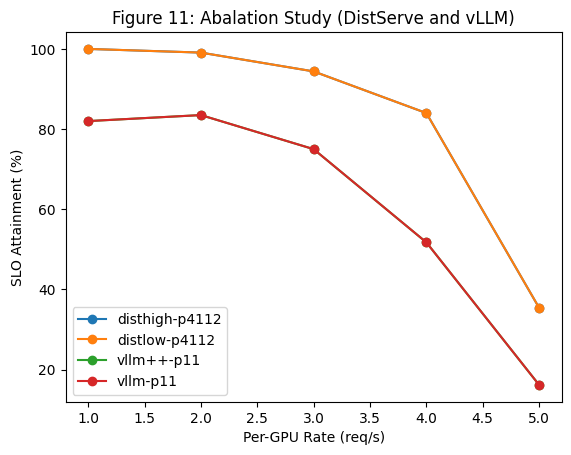

In [119]:
import matplotlib.pyplot as plt

# Plot a line chart with 4 curves
# x-axis: per_gpu_rate
# y-axis: attainment

fig, ax = plt.subplots()
a = add_matplotlib_trace(ax, figure_11_distserve_high, "disthigh")
b = add_matplotlib_trace(ax, figure_11_distserve_low, "distlow")
c = add_matplotlib_trace(ax, figure_11_vllm_high, "vllm++")
d = add_matplotlib_trace(ax, figure_11_vllm_low, "vllm")

plt.title("Figure 11: Abalation Study (DistServe and vLLM)")
plt.xlabel("Per-GPU Rate (req/s)")
plt.ylabel("SLO Attainment (%)")
plt.legend()
fig.savefig("figure/figure_11a.png")
if is_notebook_mode:
    plt.show()


In [122]:
data_points = {
    "dist++": a,
    "dist": b,
    "vllm++": c,
    "vllm": d,
}
with open("figure/figure_11a.json", "w") as f:
    import json

    json.dump(data_points, f)